In [1]:
using AutomotiveDrivingModels
using AutoViz
using BayesNets
using DataFrames
using Discretizers
using HDF5
using Interact

In [2]:
# load the data
input_filepath = "../../data/datasets/2_19/risk_10_sec_10_timesteps.h5"
features = h5open(input_filepath, "r") do file
    read(file, "risk/features")
end;

In [3]:
# get specific features of interest
debug_size = min(1000000, size(features, 3))
v = features[3,end,1:debug_size]
d_fore = features[26,end,1:debug_size]
v_fore = features[27,end,1:debug_size];

In [4]:
num_bins = 4
data = [v, d_fore, v_fore]
num_samples = length(v)
disc_data = zeros(Int, num_samples, 3)
cutpoints = []
discs = []
for (f, vals) in enumerate(data)
    disc = LinearDiscretizer(binedges(DiscretizeUniformCount(num_bins), vals))
    push!(cutpoints, disc.binedges)
    for (i, val) in enumerate(vals)
        c = 1
        while val > disc.binedges[c+1]
            c += 1
        end
        disc_data[i, f] = c
    end
end


In [5]:
# convert data to dataframe
data = DataFrame(
        velocity = disc_data[:,1], 
        foredistance = disc_data[:,2], 
        forevelocity = disc_data[:,3]
);

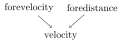

In [6]:
# fit a bayesnet
bn = fit(DiscreteBayesNet, data, (:foredistance=>:velocity, :forevelocity=>:velocity))

In [7]:
# # could also fit the structure, but skip that for now
# params = GreedyHillClimbing(ScoreComponentCache(data), max_n_parents=3, prior=UniformPrior())
# bn = fit(DiscreteBayesNet, data, params)

In [8]:
# report CPDs
for k in [:velocity, :foredistance, :forevelocity]
    println(table(bn, k))
end

64×4 DataFrames.DataFrame
│ Row │ foredistance │ forevelocity │ velocity │ p           │
├─────┼──────────────┼──────────────┼──────────┼─────────────┤
│ 1   │ 1            │ 1            │ 1        │ 0.101932    │
│ 2   │ 2            │ 1            │ 1        │ 0.78043     │
│ 3   │ 3            │ 1            │ 1        │ 0.599167    │
│ 4   │ 4            │ 1            │ 1        │ 0.102799    │
│ 5   │ 1            │ 2            │ 1        │ 0.142087    │
│ 6   │ 2            │ 2            │ 1        │ 0.197641    │
│ 7   │ 3            │ 2            │ 1        │ 0.319812    │
│ 8   │ 4            │ 2            │ 1        │ 0.0320924   │
│ 9   │ 1            │ 3            │ 1        │ 0.000552364 │
│ 10  │ 2            │ 3            │ 1        │ 0.00175734  │
│ 11  │ 3            │ 3            │ 1        │ 0.0467572   │
⋮
│ 53  │ 1            │ 2            │ 4        │ 0.00970779  │
│ 54  │ 2            │ 2            │ 4        │ 0.0133042   │
│ 55  │ 3            │ 2   

In [9]:
# generate a lane
println([collect(cs) for cs in cutpoints])
num_veh = 10
v_cpd = bn.cpds[3]
states = zeros(num_veh, 3)

# sample the initial car
state = rand(bn)
v, fore_d, fore_v = state[:velocity], state[:foredistance], state[:forevelocity]
states[1, 1] = cutpoints[1][v]
states[1, 2] = cutpoints[2][fore_d]
states[1, 3] = cutpoints[3][fore_v]

for veh_idx in 2:num_veh
    # sample the distance bin
    fore_d = rand(bn.cpds[2])
    
    # sample the velocity bin
    v = rand(bn.cpds[3], :forevelocity=>fore_v, :foredistance=>fore_d)
    
    # store the float values
    states[veh_idx, 1] = cutpoints[1][v]
    states[veh_idx, 2] = cutpoints[2][fore_d]
    states[veh_idx, 3] = cutpoints[3][fore_v]
    
    # replace the fore velocity with the current one
    fore_v = v
end

Array{Float64,1}[[-2.76668,13.5038,15.56,17.8895,33.9505],[-4.29823,18.9247,26.2396,38.7167,237.546],[-2.76668,13.5036,15.5598,17.8893,33.9505]]


In [10]:
function AutomotiveDrivingModels.simulate!(scene::Scene, models::Dict{Int, DriverModel},
        roadway::Roadway, rec::SceneRecord, T::Float64)
    actions = Array(DriveAction, length(scene))
    for t in 0:rec.timestep:(T - rec.timestep)
        get_actions!(actions, scene, roadway, models)
        tick!(scene, roadway, actions, models)
        AutomotiveDrivingModels.update!(rec, scene)
    end
    return rec
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(25, nactions=1),"i",25,"25",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(7=>"7",4=>"4",9=>"9",10=>"10",2=>"2",3=>"3",5=>"5",8=>"8",6=>"6",1=>"1"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"2.0"=>2.0,"3.0"=>3.0,"4.0"=>4.0,"5.0"=>5.0,"6.0"=>6.0,"7.0"=>7.0,"8.0"=>8.0,"9.0"=>9.0,"10.0"=>10.0…),Dict(7.0=>"7.0",4.0=>"4.0",9.0=>"9.0",10.0=>"10.0",2.0=>"2.0",3.0=>"3.0",5.0=>"5.0",8.0=>"8.0",6.0=>"6.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

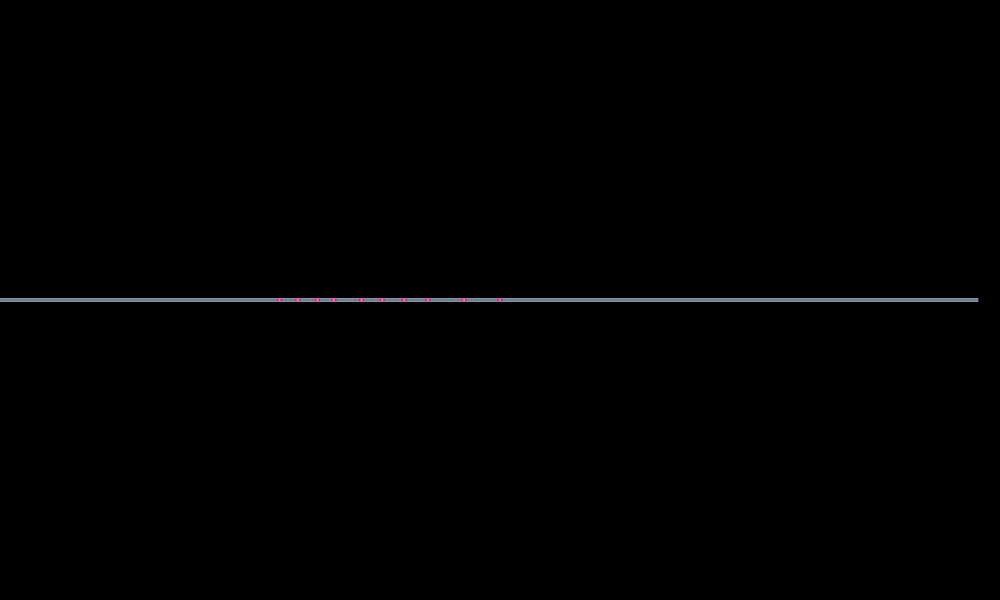

In [14]:
# populate and display a scene
context = IntegratedContinuous(.1, 1) 
num_lanes = 1
roadway_length = 1000.
remaining_length = roadway_length / 2.
roadway = gen_straight_roadway(num_lanes, roadway_length)

# unpack indices
v_idx, fore_d_idx, fore_v_idx = 1, 2, 3

# build the scene
scene = Scene(num_veh)
models = Dict{Int, DriverModel}()
for veh_idx in 1:num_veh
    remaining_length -= states[veh_idx, fore_d_idx]
    if remaining_length > 0
        road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
        base_speed = states[veh_idx, v_idx]
        veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
        veh_state = move_along(veh_state, roadway, remaining_length)
        veh_def = VehicleDef(veh_idx, AgentClass.CAR, 5., 2.)
        push!(scene, Vehicle(veh_state, veh_def))
        models[veh_idx] = Tim2DDriver(context)
    else
        break
    end
end

# simulate
rec = SceneRecord(500, .1, num_veh)
T = 5.
simulate!(scene, models, roadway, rec, T)

# display
@manipulate for i in 1:(rec.nscenes - 1), 
        id in collect(1:num_veh),
        zoom in collect(1:10.)
        render(get_scene(rec, -(rec.nscenes - i)), roadway, cam = CarFollowCamera(id, zoom))
end